In [1]:
using Pkg
Pkg.activate("./")

using DataFrames
using CSV
using TextAnalysis
using MLJ
using Chain
using Pipe
using StableRNGs
using StringEncodings
using MLJText
using MLJBase
using Plots
using WordTokenizers
using Tables

  Activating project at `~/repos/sentimental_analysis`


# Benchmark

In [2]:
using BenchmarkTools

In [4]:
function create_df()
    df = CSV.File(open("sentiment_tweets3.csv", enc"ISO-8859-1")) |> DataFrame
    rename!(df, [:Id, :Tweet, :Target])
    
    df = select!(df, Not([:Id]))
    
    return df
end

@btime create_df()

# Create Dataframe

In [6]:
df = CSV.File(open("sentiment_tweets3.csv", enc"ISO-8859-1")) |> DataFrame
rename!(df, [:Id, :Tweet, :Target])

df = select!(df, Not([:Id]))

first(df, 20)

Row,Tweet,Target
,String,Int64
1,"just had a real good moment. i missssssssss him so much,",0
2,is reading manga http://plurk.com/p/mzp1e,0
3,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0
4,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0
5,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
6,so sleepy. good times tonight though,0
7,"@SilkCharm re: #nbn as someone already said, does fiber to the home mean we will all at least be regular now",0
8,23 or 24Ã¯Â¿Â½C possible today. Nice,0
9,nite twitterville workout in the am -ciao,0


In [7]:
df.Target = coerce(df.Target, OrderedFactor)
df.Tweet = TextAnalysis.StringDocument.(df[:, :Tweet])

levels(df.Target) 

2-element Vector{Int64}:
 0
 1

In [8]:
data_plot = Plots.bar(["0", "1"], [nrow(df[(df.Target .== 0), :]), nrow(df[(df.Target .== 1), :])])

savefig(data_plot, "data_count.png")

"/home/bryan/repos/sentimental_analysis/data_count.png"

From the plot, we can see that the data is highly inbalance with data labeled as negative is almost 4x the data that is labeled positive

In [9]:
feat, target = MLJ.unpack(df, ==(:Tweet), ==(:Target))

typeof(feat)

Vector{StringDocument{String}} (alias for Array{StringDocument{String}, 1})

# Data Cleaning

In [10]:
crps = Corpus(feat)

update_lexicon!(crps)

In [11]:
remove_patterns!(crps, r"http\S+")
remove_patterns!(crps, r"#\w+")
remove_patterns!(crps, r"@\w+")

prepare!(crps, strip_case| strip_punctuation| strip_whitespace| strip_numbers| strip_non_letters| strip_stopwords| stem_words)

lexicon_df = DataFrame(lexicon(crps))

Row,!,"""",#,$,$$,$-,$APH.T,$BLO.C,$CHOO.C,$CMED.T,$CRON.V,$EMC.V,$EMH.V,$FIRE.V,$GWPH,$HIKU.C,$LEAF.T,$MYM.C,$N.C,$NINE.V,$OGI.V,$RQB.C,$SNN.C,$TER.C,$THCX.V,$WEED.T,%,&,',(,),*,+,+Junoir,+find,+scorching,+yrsWON.,",",-,-.-,-ADD,-ANXIETY,-Alexander,-BRAIN,-Check,-Come,-D,-DEPRESSION,-DKÃ\u82Â,-Day,-Eeo?aÃ\u82Â,-G/Ã\u82Â,-IRRATIONAL,-IRRITABILITY,-ISOLATION,-June,-Kelli,-Kira,-Lewis,-MEMORY,-MOOD,-NIGHT,-Nick,-No,-PANIC,-Private,-Richard,-SUICIDAL,-US$,-Um,-after-fight-against-depression-became-too-much/Ã\u82Â,-again,-b,-billion,-boeing-s-stock-was-the-best-bellwether-of-a-trade-war-until-yesterday/,-ciao,-depression,-disabilities,-engaging-physical-decreases-people-chance.htmlÃ\u82Â,-for-,-gala/Ã\u82Â,-green,-guy,-heroic-truck-drivers-line-highway-bridge-prevent-suicide-attempt-,-hic-,-hour,-i,-in-,-ins,-ish,-jess,-junk-food-factor-when-it-comes-to-depression-says-dubai-doctor?utm,-letter,-love,-mi,-min,-min?utm,-minutes-a-day-cuts-risk-developing-depression/?WT.mc,-minutes-a-day-cuts-risk-developing-depression/Ã\u82Â,-months,⋯
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,⋯
1,5578,155,1495,34,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,81,1112,4407,375,450,278,35,1,1,1,1,4205,664,1,1,1,1,1,1,1,9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,2,1,1,⋯


In [12]:
rng = StableRNG(100)
train, test = partition(eachindex(target), 0.7, shuffle=true, rng=rng);

# MNB

In [13]:
MultinomialNBClassifier = @load MultinomialNBClassifier pkg=NaiveBayes

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/bryan/.julia/packages/MLJModels/ubqRh/src/loading.jl:159


import MLJNaiveBayesInterface ✔

MLJNaiveBayesInterface.MultinomialNBClassifier

## Multinomial Naive Bayes Classifier With TF-IDF Vectorizer

### Create Model Pipeline

In [8]:
MultinomialNBClassifier = @load MultinomialNBClassifier pkg=NaiveBayes
multinomial_nb_classifier_tfidf_pipe = 
    (feat -> tokenize.(TextAnalysis.text.(feat))) |> 
    TfidfTransformer() |> 
    (feat -> round.(feat)) |> MultinomialNBClassifier()

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/bryan/.julia/packages/MLJModels/OJDDo/src/loading.jl:159


import MLJNaiveBayesInterface ✔


ProbabilisticPipeline(
  f = var"#11#13"(), 
  tfidf_transformer = TfidfTransformer(
        max_doc_freq = 1.0, 
        min_doc_freq = 0.0, 
        smooth_idf = true), 
  f2 = var"#12#14"(), 
  multinomial_nb_classifier = MultinomialNBClassifier(
        alpha = 1), 
  cache = true)

### Fit Data Into Model

In [16]:
mach = machine(multinomial_nb_classifier_tfidf_pipe, feat, target)
MLJ.fit!(mach, rows=train)

params = fitted_params(mach)

params

┌ Info: Training machine(ProbabilisticPipeline(f = #9, …), …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492
┌ Info: Training machine(:tfidf_transformer, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492
┌ Info: Training machine(:multinomial_nb_classifier, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492


(multinomial_nb_classifier = (c_counts = Dict{CategoricalArrays.CategoricalValue{Int64, UInt32}, Int64}(0 => 5601, 1 => 1621),
                              x_counts = Dict{CategoricalArrays.CategoricalValue{Int64, UInt32}, Vector{Number}}(0 => [1, 3, 1, 1, 1, 3, 2, 1, 3, 4  …  3, 3, 1, 2, 2, 2, 1, 2, 2, 2], 1 => [2, 1, 3, 3, 3, 1, 1, 2, 1, 1  …  1, 1, 2, 1, 1, 1, 2, 1, 1, 1]),
                              x_totals = Number[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0, 5.0  …  4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
                              n_obs = 27944,),
 tfidf_transformer = (vocab = ["aaa", "aaaaaaaaaaaaa", "aaaaaaaand", "aaaaaah", "aaaaayyyyy", "aaaand", "aaah", "aaahhhh", "aaahhhhhh", "aahh"  …  "zomg", "zone", "zonepray", "zoo", "zoot", "zx", "zzz", "zzzz", "zzzzz", "zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz"],
                      idf_vector = [9.191601545891237, 9.191601545891237, 9.191601545891237, 9.191601545891237, 9.191601545891237, 9.191601545891237, 9.19160154

### Evaluate Model Pipeline

In [11]:
evaluation = evaluate!(mach, resampling=CV(), measure=[Accuracy(), Precision(), TruePositiveRate(), FScore(), LogLoss()], rows=test)
println(evaluation)

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/resampling.jl:601
Evaluating over 6 folds: 100%[=========================] Time: 0:00:31


PerformanceEvaluation(0.899, 0.771, 0.782, 0.776, 0.342)


### Plot Confusion Matrix

Accuracy on the test set: 0.9573367808661927
fscore on the test set: 0.9016393442622951
MLJBase.ConfusionMatrixObject{2}([2357 89; 43 605], ["0", "1"])


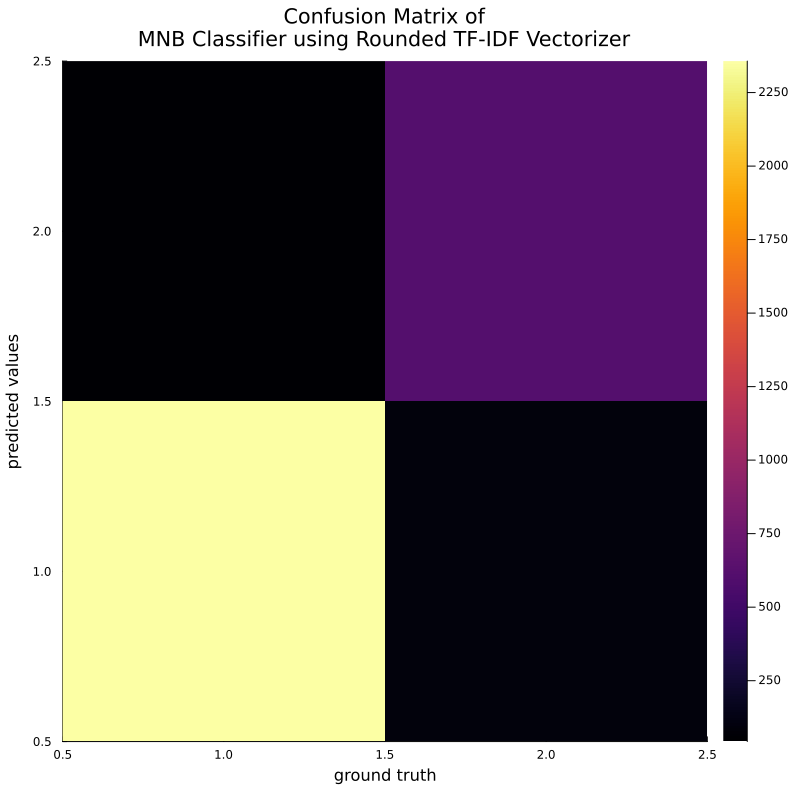

In [13]:
yhat = MLJ.predict(mach, rows=test)

println("Accuracy on the test set: $(MLJ.accuracy(mode.(yhat), target[test]))")
println("fscore on the test set: $(MLJ.f1score(mode.(yhat), target[test]))")

confusion_mat = ConfusionMatrix()(mode.(yhat), coerce(target[test], OrderedFactor))
println(confusion_mat)
cm_plt = Plots.heatmap(confusion_mat.mat, xlabel="ground truth", ylabel="predicted values", title="Confusion Matrix of\nMNB Classifier using Rounded TF-IDF Vectorizer", size= (800, 800))


## Multinomial Naive Bayes Classifier With Count Vectorizer

### Create Pipeline

In [14]:
# CountTransformer = @load CountTransformer pkg=MLJText
multinomial_nb_classifier_count_pipe = (feat -> tokenize.(TextAnalysis.text.(feat))) |> CountTransformer() |> MultinomialNBClassifier()

ProbabilisticPipeline(
  f = var"#11#12"(), 
  count_transformer = CountTransformer(
        max_doc_freq = 1.0, 
        min_doc_freq = 0.0), 
  multinomial_nb_classifier = MultinomialNBClassifier(
        alpha = 1), 
  cache = true)

### Fit Data Into Pipeline

In [15]:
mach = machine(multinomial_nb_classifier_count_pipe, feat, target)
MLJ.fit!(mach, rows=train)
params = fitted_params(mach)

params

┌ Info: Training machine(ProbabilisticPipeline(f = #11, …), …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/5cxU0/src/machines.jl:492


┌ Info: Training machine(:count_transformer, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/5cxU0/src/machines.jl:492


┌ Info: Training machine(:multinomial_nb_classifier, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/5cxU0/src/machines.jl:492


(multinomial_nb_classifier = (c_counts = Dict{CategoricalArrays.CategoricalValue{Int64, UInt32}, Int64}(0 => 5601, 1 => 1621),
                              x_counts = Dict{CategoricalArrays.CategoricalValue{Int64, UInt32}, Vector{Number}}(0 => [3, 1, 2, 1, 1, 1, 2, 2, 1, 2  …  4, 2, 1, 2, 2, 2, 1, 2, 2, 2], 1 => [2, 2, 1, 2, 2, 2, 1, 1, 2, 1  …  1, 2, 2, 1, 1, 1, 2, 1, 1, 1]),
                              x_totals = Number[5.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0  …  5.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
                              n_obs = 26700,),
 count_transformer = (vocab = ["a", "aaa", "aaaaaaaaaaaaa", "aaaaaaaand", "aaaaaah", "aaaaayyyyy", "aaaand", "aaah", "aaahhhh", "aaahhhhhh"  …  "zomg", "zone", "zonepray", "zoo", "zoot", "zx", "zzz", "zzzz", "zzzzz", "zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz"],),)

### Evaluate Model Performance

In [16]:
evaluation = evaluate!(mach, resampling=CV(), measure=[Accuracy(), Precision(), recall, FScore(), LogLoss()], rows=test)
println(evaluation)

evaluation

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/5cxU0/src/resampling.jl:601


Evaluating over 6 folds:  33%[========>                ]  ETA: 0:02:54

Evaluating over 6 folds:  50%[============>            ]  ETA: 0:01:42

Evaluating over 6 folds:  67%[================>        ]  ETA: 0:00:57

Evaluating over 6 folds:  83%[====================>    ]  ETA: 0:00:25

Evaluating over 6 folds: 100%[=========================] Time: 0:02:18


PerformanceEvaluation(0.964, 0.898, 0.949, 0.923, 0.116)


PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────────────┬──────────────┬─────────────┬─────────┬───────
│ measure                        │ operation    │ measurement │ 1.96*SE │ per_ ⋯
├────────────────────────────────┼──────────────┼─────────────┼─────────┼───────
│ Accuracy()                     │ predict_mode │ 0.964       │ N/A     │ [0.9 ⋯
│ Precision(                     │ predict_mode │ 0.898       │ N/A     │ [0.8 ⋯
│   rev = nothing)               │              │             │         │      ⋯
│ TruePositiveRate(              │ predict_mode │ 0.949       │ N/A     │ [0.9 ⋯
│   rev = nothing)               │              │             │         │      ⋯
│ FScore(                        │ predict_mode │ 0.923       │ N/A     │ [0.9 ⋯
│   β = 1.0,                     │              │             │         │      ⋯
│   rev = 

### Plot Confusion Matrix

Accuracy on the test set: 0.989010989010989
fscore on the test set: 0.9756446991404012
MLJBase.ConfusionMatrixObject{2}([2379 13; 21 681], ["0", "1"])


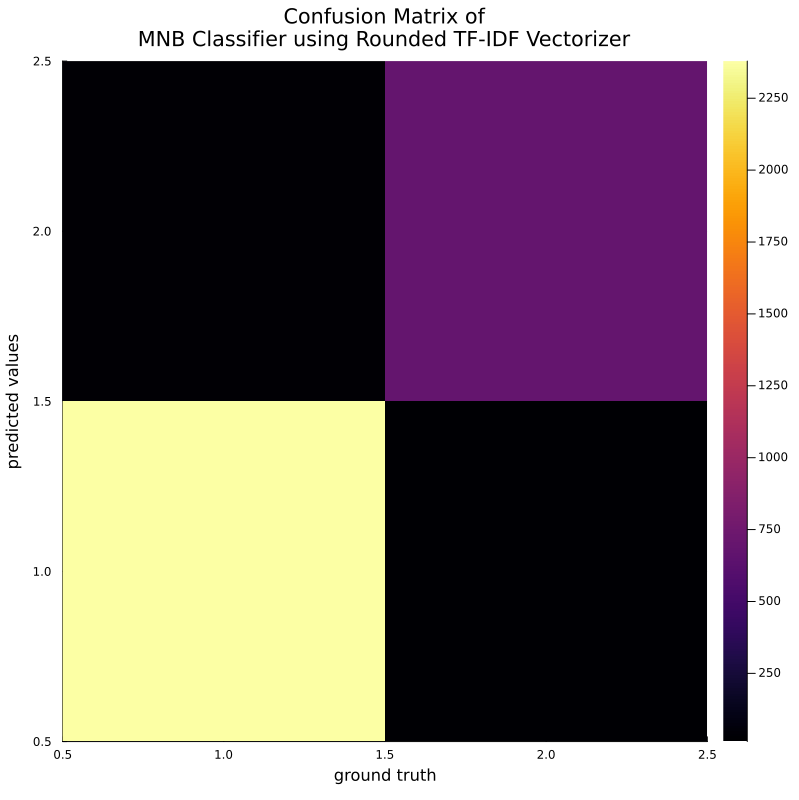

In [95]:
yhat = MLJ.predict(mach, rows=test)

println("Accuracy on the test set: $(MLJ.accuracy(mode.(yhat), target[test]))")
println("fscore on the test set: $(MLJ.f1score(mode.(yhat), target[test]))")

confusion_mat = ConfusionMatrix()(mode.(yhat), coerce(target[test], OrderedFactor))
println(confusion_mat)
cm_plt = Plots.heatmap(confusion_mat.mat, xlabel="ground truth", ylabel="predicted values", title="Confusion Matrix of\nMNB Classifier using Rounded TF-IDF Vectorizer", size= (800, 800))

# Random Forest Classifier

In [10]:
RandomForestClassifier = @load RandomForestClassifier pkg=DecisionTree

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/bryan/.julia/packages/MLJModels/OJDDo/src/loading.jl:159


import MLJDecisionTreeInterface ✔


MLJDecisionTreeInterface.RandomForestClassifier

## Random Forest With TF-IDF Vectorizer

### Create Model Pipeline

In [9]:
random_forest_classifier_tfidf_pipeline = (feat -> TextAnalysis.text.(feat)) |> TfidfTransformer() |> (feat -> Tables.table(feat)) |> RandomForestClassifier(min_samples_split=6, n_subfeatures=3)

UndefVarError: UndefVarError: RandomForestClassifier not defined

### Fit Data Into The Pipeline

In [25]:
mach = machine(random_forest_classifier_tfidf_pipeline, feat, target)

mach

untrained Machine; does not cache data
  model: ProbabilisticPipeline(f = #11, …)
  args: 
    1:	Source @720 ⏎ AbstractVector{Unknown}
    2:	Source @579 ⏎ AbstractVector{OrderedFactor{2}}


In [26]:
MLJ.fit!(mach, rows=train)

trained Machine; does not cache data
  model: ProbabilisticPipeline(f = #11, …)
  args: 
    1:	Source @720 ⏎ AbstractVector{Unknown}
    2:	Source @579 ⏎ AbstractVector{OrderedFactor{2}}


### Evaluate Model Pipeline

In [27]:
evaluation = evaluate!(mach, resampling=CV(), measure=[Accuracy(), Precision(), TruePositiveRate(), FScore(), ConfusionMatrix()], rows=test)
println(evaluation)

evaluation

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌───────────────────┬──────────────┬────────────────────────────────────────────
│ measure           │ operation    │ measurement                               ⋯
├───────────────────┼──────────────┼────────────────────────────────────────────
│ Accuracy()        │ predict_mode │ 0.956                                     ⋯
│ Precision(        │ predict_mode │ 1.0                                       ⋯
│   rev = nothing)  │              │                                           ⋯
│ TruePositiveRate( │ predict_mode │ 0.805                                     ⋯
│   rev = nothing)  │              │                                           ⋯
│ FScore(           │ predict_mode │ 0.891                                     ⋯
│   β = 1.0,        │              │                                           ⋯
│   rev = 

## Random Forest With Count Vectorizer

### Create Model Pipeline

In [11]:
random_forest_classifier_count_pipeline = (feat -> TextAnalysis.text.(feat)) |> CountTransformer() |> (feat -> Tables.table(feat)) |> RandomForestClassifier()

ProbabilisticPipeline(
  f = var"#17#19"(), 
  count_transformer = CountTransformer(
        max_doc_freq = 1.0, 
        min_doc_freq = 0.0), 
  f2 = var"#18#20"(), 
  random_forest_classifier = RandomForestClassifier(
        max_depth = -1, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = -1, 
        n_trees = 100, 
        sampling_fraction = 0.7, 
        feature_importance = :impurity, 
        rng = Random._GLOBAL_RNG()), 
  cache = true)

### Fit Data Into The Pipeline

In [12]:
mach = machine(random_forest_classifier_count_pipeline, feat, target)

MLJ.fit!(mach, rows=train)

fitted_params(mach)

┌ Info: Training machine(ProbabilisticPipeline(f = #17, …), …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492
┌ Info: Training machine(:count_transformer, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492
┌ Info: Training machine(:random_forest_classifier, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492


(random_forest_classifier = (forest = Ensemble of Decision Trees
Trees:      100
Avg Leaves: 1042.0
Avg Depth:  650.26,),
 count_transformer = (vocab = ["a", "aaa", "aaaaaaaaaaaaa", "aaaaaaaand", "aaaaaah", "aaaaayyyyy", "aaaand", "aaah", "aaahhhh", "aaahhhhhh"  …  "zomg", "zone", "zonepray", "zoo", "zoot", "zx", "zzz", "zzzz", "zzzzz", "zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz"],),)

### Evaluate Model Pipeline

In [13]:
evaluation = evaluate!(mach, resampling=CV(), measure=[Accuracy(), Precision(), TruePositiveRate(), FScore(), ConfusionMatrix()], rows=test)

evaluation

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/resampling.jl:601
Evaluating over 6 folds: 100%[=========================] Time: 0:06:51


PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌───────────────────┬──────────────┬────────────────────────────────────────────
│ measure           │ operation    │ measurement                               ⋯
├───────────────────┼──────────────┼────────────────────────────────────────────
│ Accuracy()        │ predict_mode │ 0.98                                      ⋯
│ Precision(        │ predict_mode │ 1.0                                       ⋯
│   rev = nothing)  │              │                                           ⋯
│ TruePositiveRate( │ predict_mode │ 0.91                                      ⋯
│   rev = nothing)  │              │                                           ⋯
│ FScore(           │ predict_mode │ 0.953                                     ⋯
│   β = 1.0,        │              │                                           ⋯
│   rev = 

# SVC

In [9]:
SVC = @load SVC pkg=LIBSVM
svc = SVC()

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/bryan/.julia/packages/MLJModels/OJDDo/src/loading.jl:159


import MLJLIBSVMInterface ✔


SVC(
  kernel = LIBSVM.Kernel.RadialBasis, 
  gamma = 0.0, 
  cost = 1.0, 
  cachesize = 200.0, 
  degree = 3, 
  coef0 = 0.0, 
  tolerance = 0.001, 
  shrinking = true)

## SVC With TF-IDF Vectorizer

### Create SVC Model Pipeline

In [8]:
svc_tfidf_pipeline = (feat -> tokenize.(TextAnalysis.text.(feat))) |> TfidfTransformer() |> (feat -> round.(feat)) |> svc

svc_tfidf_pipeline

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/bryan/.julia/packages/MLJModels/OJDDo/src/loading.jl:159


import MLJLIBSVMInterface ✔


DeterministicPipeline(
  f = var"#9#11"(), 
  tfidf_transformer = TfidfTransformer(
        max_doc_freq = 1.0, 
        min_doc_freq = 0.0, 
        smooth_idf = true), 
  f2 = var"#10#12"(), 
  svc = SVC(
        kernel = LIBSVM.Kernel.RadialBasis, 
        gamma = 0.0, 
        cost = 1.0, 
        cachesize = 200.0, 
        degree = 3, 
        coef0 = 0.0, 
        tolerance = 0.001, 
        shrinking = true), 
  cache = true)

In [39]:
r = MLJ.range(svc_tfidf_pipeline, :(svc.gamma), lower=0.001, upper=1.0, scale=:log)
tuned_svc_tfidf_pipeline = TunedModel(; model=svc_tfidf_pipeline, tuning=Grid(resolution=10), resampling=CV(), range=r, measure=misclassification_rate)

DeterministicTunedModel(
  model = DeterministicPipeline(
        f = var"#25#27"(), 
        tfidf_transformer = TfidfTransformer(max_doc_freq = 1.0, …), 
        f2 = var"#26#28"(), 
        svc = SVC(kernel = RadialBasis, …), 
        cache = true), 
  tuning = Grid(
        goal = nothing, 
        resolution = 10, 
        shuffle = true, 
        rng = Random._GLOBAL_RNG()), 
  resampling = CV(
        nfolds = 6, 
        shuffle = false, 
        rng = Random._GLOBAL_RNG()), 
  measure = MisclassificationRate(), 
  weights = nothing, 
  class_weights = nothing, 
  operation = nothing, 
  range = NumericRange(0.001 ≤ svc.gamma ≤ 1.0; origin=0.5005, unit=0.4995; on log scale), 
  selection_heuristic = MLJTuning.NaiveSelection(nothing), 
  train_best = true, 
  repeats = 1, 
  n = nothing, 
  acceleration = CPU1{Nothing}(nothing), 
  acceleration_resampling = CPU1{Nothing}(nothing), 
  check_measure = true, 
  cache = true)

### Fit Data Into Pipeline

In [9]:
mach = machine(svc_tfidf_pipeline, feat, target)
MLJ.fit!(mach, rows=train)
params = fitted_params(mach)

params

┌ Info: Training machine(DeterministicPipeline(f = #9, …), …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492
┌ Info: Training machine(:tfidf_transformer, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492
┌ Info: Training machine(:svc, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492


(svc = (libsvm_model = LIBSVM.SVM{UInt32, LIBSVM.Kernel.KERNEL}(LIBSVM.SVC, LIBSVM.Kernel.RadialBasis, nothing, 10504, 7220, 2, UInt32[0x00000001, 0x00000002], Int32[1, 2], Float64[], Int32[], LIBSVM.SupportVectors{Vector{UInt32}, SparseArrays.SparseMatrixCSC{Float64, Int64}}(3292, Int32[2107, 1185], UInt32[0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001  …  0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002], sparse([1196, 2403, 2677, 6787, 7022, 7396, 9175, 1260, 3134, 5974  …  10062, 10186, 317, 1855, 2045, 4192, 6006, 6678, 8010, 8994], [1, 1, 1, 1, 1, 1, 1, 2, 2, 2  …  3291, 3291, 3292, 3292, 3292, 3292, 3292, 3292, 3292, 3292], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 10504, 3292), Int32[2, 10, 11, 12, 13, 19, 20, 26, 30, 35  …  7180, 7183, 7187, 7191, 7197, 7199, 7201, 7202, 7217

### Evaluate Pipeline

In [10]:
evaluation = evaluate!(mach, resampling=CV(), measure=[Accuracy(), Precision(), TruePositiveRate(), FScore(), ConfusionMatrix()], rows=test)
println(evaluation)

evaluation

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/resampling.jl:601
Evaluating over 6 folds: 100%[=========================] Time: 0:07:02


PerformanceEvaluation(0.895, 0.829, 0.674, 0.743, MLJBase.ConfusionMatrixObject{2}([2302 226; 98 468], ["0", "1"]))


### Plot Confusion Matrix

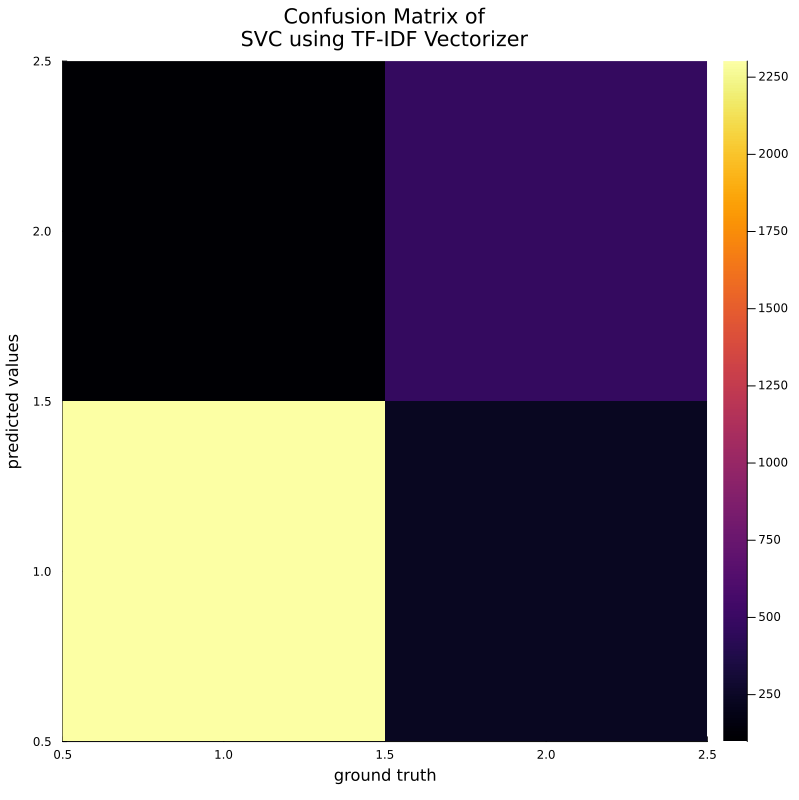

In [11]:
yhat = MLJ.predict(mach, rows=test)

# println("Accuracy on the test set: $(MLJ.accuracy(mode.(yhat), target[test]))")
# println("fscore on the test set: $(MLJ.f1score(mode.(yhat), target[test]))")

# confusion_mat = ConfusionMatrix()(mode.(yhat), coerce(target[test], OrderedFactor))
# println(confusion_mat)
cm_plt = Plots.heatmap(evaluation.measurement[5].mat, xlabel="ground truth", ylabel="predicted values", title="Confusion Matrix of\nSVC using TF-IDF Vectorizer", size= (800, 800))

# MLJ.misclassification_ rate(yhat, target[test])



## SVC With Count Vectorizer

### Create SVC Model Pipeline

In [10]:
svc_count_pipeline = (feat -> tokenize.(TextAnalysis.text.(feat))) |> CountTransformer() |> svc

DeterministicPipeline(
  f = var"#9#10"(), 
  count_transformer = CountTransformer(
        max_doc_freq = 1.0, 
        min_doc_freq = 0.0), 
  svc = SVC(
        kernel = LIBSVM.Kernel.RadialBasis, 
        gamma = 0.0, 
        cost = 1.0, 
        cachesize = 200.0, 
        degree = 3, 
        coef0 = 0.0, 
        tolerance = 0.001, 
        shrinking = true), 
  cache = true)

### Fit Data Into Pipeline

In [13]:
mach = machine(svc_count_pipeline, feat, target)
MLJ.fit!(mach, rows=train)
params = fitted_params(mach)

params

┌ Info: Training machine(DeterministicPipeline(f = #9, …), …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492
┌ Info: Training machine(:count_transformer, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492
┌ Info: Training machine(:svc, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492


(svc = (libsvm_model = LIBSVM.SVM{UInt32, LIBSVM.Kernel.KERNEL}(LIBSVM.SVC, LIBSVM.Kernel.RadialBasis, nothing, 9740, 7220, 2, UInt32[0x00000001, 0x00000002], Int32[1, 2], Float64[], Int32[], LIBSVM.SupportVectors{Vector{UInt32}, SparseArrays.SparseMatrixCSC{Int64, Int64}}(2036, Int32[1300, 736], UInt32[0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001, 0x00000001  …  0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002, 0x00000002], sparse([1193, 2395, 2668, 6035, 6270, 6644, 8416, 1473, 2945, 5609  …  6038, 6258, 6830, 316, 1851, 2041, 5256, 5926, 7257, 8236], [1, 1, 1, 1, 1, 1, 1, 2, 2, 2  …  2035, 2035, 2035, 2036, 2036, 2036, 2036, 2036, 2036, 2036], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 9740, 2036), Int32[2, 5, 13, 16, 17, 19, 20, 40, 42, 48  …  7148, 7151, 7152, 7171, 7180, 7183, 7191, 7197, 7202, 7218], LIBSVM.SVMNode[LIBSVM.SVMNode(1193, 1.0

### Evaluate Pipeline

In [14]:
evaluation = evaluate!(mach, resampling=CV(), measure=[Accuracy(), Precision(), TruePositiveRate(), FScore(), ConfusionMatrix()], rows=test)
println(evaluation)

evaluation

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/resampling.jl:601
Evaluating over 6 folds: 100%[=========================] Time: 0:00:12


PerformanceEvaluation(0.977, 1.0, 0.899, 0.946, MLJBase.ConfusionMatrixObject{2}([2400 70; 0 624], ["0", "1"]))


PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌───────────────────┬───────────┬───────────────────────────────────────────────
│ measure           │ operation │ measurement                                  ⋯
├───────────────────┼───────────┼───────────────────────────────────────────────
│ Accuracy()        │ predict   │ 0.977                                        ⋯
│ Precision(        │ predict   │ 1.0                                          ⋯
│   rev = nothing)  │           │                                              ⋯
│ TruePositiveRate( │ predict   │ 0.899                                        ⋯
│   rev = nothing)  │           │                                              ⋯
│ FScore(           │ predict   │ 0.946                                        ⋯
│   β = 1.0,        │           │                                              ⋯
│   rev = 